# MLHAT - Tutorial of execution

This notework shows an example steps sequences to declare, use and evaluate a MLHAT model in the proposed framework.

## Multi-label data streams

The datasets used in this experimentation are publicly available in the [Multi-Label Classification Dataset Repository](https://www.uco.es/kdis/mllresources/). To be used in this framework they have been wrapped in the wrapper for the River data streams under the `datasetsmultioutput` package. More information about reading data in River can be found [here](https://riverml.xyz/0.17.0/recipes/reading-data/). Next, the *CHD* dataset is loaded below as an example.

In [1]:
from datasetsmultioutput import *

stream = Emotions()
stream

Also called Music. Is a small dataset to classify music into emotions that it evokes according to the Tellegen-Watson-Clark model of mood: amazed-suprised, happy-pleased, relaxing-calm, quiet-still, sad-lonely and angry-aggresive. It consists of 593 songs with 6 classes.

G. Tsoumakas, I. Katakis, and I. Vlahavas. Effective and Efficient Multilabel Classification in Domains with Large Number of Labels. In Proc. ECML/PKDD 2008 Workshop on Mining Multidimensional Data (MMD'08), 2008.

      Name  Emotions                                                                              
      Task  Multi-output binary classification                                                    
   Samples  593                                                                                   
  Features  72                                                                                    
   Outputs  6                                                                                     
    Sparse  False

We can also take a look to the first sample, which is composed of two Python dictionaries: one for the input features and one with the label set that would be activated in the output space from the input:

In [2]:
x, y = next(iter(stream))
print("Input:", x)
print("Output:", y)

Input: {'Mean_Acc1298_Mean_Mem40_Centroid': 0.034741, 'Mean_Acc1298_Mean_Mem40_Rolloff': 0.089665, 'Mean_Acc1298_Mean_Mem40_Flux': 0.091225, 'Mean_Acc1298_Mean_Mem40_MFCC_0': -73.302422, 'Mean_Acc1298_Mean_Mem40_MFCC_1': 6.215179, 'Mean_Acc1298_Mean_Mem40_MFCC_2': 0.615074, 'Mean_Acc1298_Mean_Mem40_MFCC_3': 2.03716, 'Mean_Acc1298_Mean_Mem40_MFCC_4': 0.804065, 'Mean_Acc1298_Mean_Mem40_MFCC_5': 1.301409, 'Mean_Acc1298_Mean_Mem40_MFCC_6': 0.558576, 'Mean_Acc1298_Mean_Mem40_MFCC_7': 0.672063, 'Mean_Acc1298_Mean_Mem40_MFCC_8': 0.783788, 'Mean_Acc1298_Mean_Mem40_MFCC_9': 0.76664, 'Mean_Acc1298_Mean_Mem40_MFCC_10': 0.458712, 'Mean_Acc1298_Mean_Mem40_MFCC_11': 0.530384, 'Mean_Acc1298_Mean_Mem40_MFCC_12': 0.812429, 'Mean_Acc1298_Std_Mem40_Centroid': 0.028851, 'Mean_Acc1298_Std_Mem40_Rolloff': 0.129039, 'Mean_Acc1298_Std_Mem40_Flux': 0.039614, 'Mean_Acc1298_Std_Mem40_MFCC_0': 5.762173, 'Mean_Acc1298_Std_Mem40_MFCC_1': 1.636819, 'Mean_Acc1298_Std_Mem40_MFCC_2': 1.170034, 'Mean_Acc1298_Std_Mem40_M

## Loading the Multi-label Hoeffding Adaptive Tree

Below is shown how an instance of MLHAT would be initialized with the default parameters:
* Leaf grace period $k_{spl}$: `grace_period=200`.
* Significance level in Hoeffding bound for spliting nodes $\delta_{spl}$: `delta=1e-7`.
* Alternate tree grace period $k_{alt}$: `drift_window_threshold=200`.
* Significance level in Hoeffdinb bound for switching alternate trees $\delta_{alt}$: `switch_significance=0.05`.
* Cardinality threshold $\eta$ and number of instance a leaf should observe between split attemps grouped in: `grace_period=750`.
* Applying bootstrap sampling and its Poisson distribution $\lambda$: `bootstrap_sampling=True`, `poisson_rate=1.0`.
* Metric to study the concept drift $e$: `perf_metric=HammingLoss()`.
* Low cardinality classifier: `low_card_clf=LabelCombination(KNNClassifier(4))`.
* High cardinality classifier: `high_card_clf=BinaryRelevance(BaggingClassifier(LogisticRegression(), n_models=10))`

In [2]:
from multioutput import MLHAT

mlhat = MLHAT()
mlhat

MLHAT (
  grace_period=200
  delta=2e-07
  drift_window_threshold=200
  switch_significance=0.05
  cardinality_th=750
  poisson_rate=1.
  tau=0.05
  splitter=GaussianSplitter (
    n_splits=10
  )
  entropy_th=0.3
  low_card_clf=LabelCombination
  high_card_clf=BinaryRelevance(BaggingClassifier(LogisticRegression))
  bootstrap_sampling=True
  drift_detector=ADWIN (
    delta=0.002
    clock=32
    max_buckets=5
    min_window_length=5
    grace_period=10
  )
  drift_method="per labelset"
  perf_metric=HammingLoss: 0.
  alternate_strategy="on warning"
  combined_prediction=True
  min_branch_fraction=0.01
  max_share_to_split=0.99
  nominal_attributes=None
  max_depth=inf
  max_size=100
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
  seed=0
)

At the beginning, since no data has been received yet, the tree will be empty: 

In [3]:
mlhat.summary

{'n_nodes': None,
 'n_branches': None,
 'n_leaves': None,
 'n_active_leaves': None,
 'n_inactive_leaves': None,
 'height': 0,
 'total_observed_weight': 0.0,
 'n_current_alternate_trees': None,
 'n_pruned_alternate_trees': 0,
 'n_switched_alternate_trees': 0}

## Prequential evaluation of the model

Prequential assessment is the canonical form of stream learning. This evaluation framework allows to check the performance of the model at each step of the stream and how well it adapts to the concept drift.

The code below allows to apply prequential evaluation to MLHAT by measuring its performance every 30 steps in the data stream. In addition, it also shows how the tree grows the more instances it receives.

In [3]:
from river.metrics import F1
from river.metrics.base import Metrics
from river.metrics.multioutput import ExactMatch, MacroAverage, MicroAverage
import evaluate

evaluate.progressive_val_score(dataset=stream, model=mlhat, metric=Metrics([ExactMatch(), MacroAverage(F1()), MicroAverage(F1())]), show_memory=True, print_every=30)

[30] ExactMatch: 3.45%
MacroAverage(F1): 37.22%
MicroAverage(F1): 39.18% – 1.95 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 48.0, 'n_current_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switched_alternate_trees': 0}
[60] ExactMatch: 3.39%
MacroAverage(F1): 33.57%
MicroAverage(F1): 37.50% – 2.07 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 94.0, 'n_current_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switched_alternate_trees': 0}
[90] ExactMatch: 6.74%
MacroAverage(F1): 38.63%
MicroAverage(F1): 43.60% – 2.19 MB –  Model: {'n_nodes': 1, 'n_branches': 0, 'n_leaves': 1, 'n_active_leaves': 1, 'n_inactive_leaves': 0, 'height': 1, 'total_observed_weight': 130.0, 'n_current_alternate_trees': 0, 'n_pruned_alternate_trees': 0, 'n_switched_alternate_trees': 0}
[120] ExactMatch: 9.2

ExactMatch: 16.89%
MacroAverage(F1): 46.52%
MicroAverage(F1): 48.63%

The final average exact match (or subset accuracy) is 16.89%, while micro and macro averaged F1 are 46.52% and 48.63% respectively. The final tree has 4 nodes distributed in 1 branch, 2 leaves and 1 node in the background as alternative tree. The total tree height is 2.

In [4]:
mlhat.summary

{'n_nodes': 4,
 'n_branches': 1,
 'n_leaves': 2,
 'n_active_leaves': 2,
 'n_inactive_leaves': 0,
 'height': 2,
 'total_observed_weight': 808.0,
 'n_current_alternate_trees': 1,
 'n_pruned_alternate_trees': 0,
 'n_switched_alternate_trees': 0}

The `draw()` method shows the current tree with the majority label set for each leaf, the active leaf classifier and the probabilities of occurrence of each label:

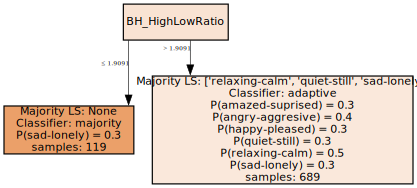

In [5]:
mlhat.draw()

In [6]:
mlhat.to_dataframe()

,parent,is_leaf,depth,drift_detector,_mean_perf,_post_drift_weight,warning,stats,feature,threshold,...,_alternate_tree,splitter,splitters,_disabled_attrs,_last_split_attempt_at,current_weight,pure_clf,entropy,low_card_clf,high_card_clf
node,,,,,,,,,,,,,,,,,,,,,
0,<NA>,False,0,ADWIN,HammingLoss: 0.3015,409,False,"{'happy-pleased': 223, 'relaxing-calm': 357, '...",BH_HighLowRatio,1.909091,...,MLHAToCLeaf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,<NA>,True,0,ADWIN,HammingLoss: 0.2997,406,False,"{'relaxing-calm': 194, 'sad-lonely': 140, 'tot...",NaN,NaN,...,NaN,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},400.000000,408.0,MajorityLabelset,0.0,LabelCombination,"[amazed-suprised, happy-pleased, relaxing-calm..."
2,0,True,1,ADWIN,HammingLoss: 0.,0,False,"{'total': 119.17738453200997, 'sad-lonely': 30...",NaN,NaN,...,NaN,GaussianSplitter,{},{},119.177385,0.0,MajorityLabelset,0.0,LabelCombination,[]
3,0,True,1,ADWIN,HammingLoss: 0.3015,409,False,"{'happy-pleased': 223, 'relaxing-calm': 357, '...",NaN,NaN,...,NaN,GaussianSplitter,{'Mean_Acc1298_Mean_Mem40_Centroid': GaussianS...,{},280.822615,409.0,MajorityLabelset,0.0,LabelCombination,"[amazed-suprised, happy-pleased, relaxing-calm..."
